# Constructing Social Networks in the Bible

### <i>Lemuel Kumarga</i>


## Problem Description

Our social circles are huge parts of our lives. They represent who we interact with, and how much we interact with them. With the digitization of communication and socialization, finding out this circle within each individual is an easier task than before. A simple glimpse into social networking sites such as Facebook and LinkedIn allows us to see who our friends are, whilst the frequency of digital communication can be used as a proxy of our closeness with them.

However, such information was not easily quantifiable in the pre-technology era. By attempting to model past lives using modern concepts, we could potentially gain further information about the past. For this project, we will use Natural Language Processing (NLP) concepts to <b>construct a social network for the bible, with the aim to depeen our understanding of the gospel.</b>


## Preliminaries

First load the necessary modules for this exercise.

In [91]:
import sys
sys.path.append('shared/')
from defaults import *

# Load All Main Modules
load({"pd":"pandas",
      "math":"math",
      "cl":"collections",
      "np":"numpy",
      "sp":"scipy",
      "re":"re",
      "mpl":"matplotlib",
      "nltk":"nltk",
      "wordcloud":"wordcloud",
      "PIL":"PIL",
      "operator":"operator"})

# Load All Submodules
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# If you can't find the module, run nltk.download() in python
from nltk import sent_tokenize, word_tokenize

defaults()

## Exploration

### Loading the Data

For this exercise, we will be using the bible <a data-toggle="popover" title="" data-content="A collection of texts" data-original-title="Corpus">corpus</a> from <a href="https://www.kaggle.com/oswinrh/bible/data">Kaggle.</a> The data will be stored in abbreviated book keys, with each book containing the following attributes:

* <span class="hl">Book Name</span>: Full name of the book
* <span class="hl">Testament</span>: New (NT) or old (OT)
* <span class="hl">Genre</span>: Genre of the book
* <span class="hl">Chapters</span>: Number of chapters
* <span class="hl">Verses</span>: Total number of verses
* <span class="hl">Text</span>: The actual text of the book



In [4]:
# Get all book statistics
abb = pd.read_csv("data/key_abbreviations_english.csv")\
        .query('p == 1')[["a","b"]]\
        .rename(columns={"a" : "Key"})
ot_nt = pd.read_csv("data/key_english.csv")\
          .rename(columns={"n" : "Name", "t" : "Testament"})
genres = pd.read_csv("data/key_genre_english.csv")\
           .rename(columns={"n" : "Genre"})

# Load the main biblical text
bible = pd.read_csv("data/t_asv.csv")\
          .groupby("b", as_index=False)\
          .agg({"c": pd.Series.nunique, "v": "size", "t":" ".join})\
          .rename(columns={"c": "Chapters","v": "Verses","t": "Text"})

# Join the remaining book statistics
bible = bible.join(abb.set_index('b'), on='b')\
             .join(ot_nt.set_index('b'), on='b')\
             .join(genres.set_index('g'), on='g')\
             .drop(['b', 'g'], axis=1)\
             .set_index('Key')\
             [["Name","Testament","Genre","Chapters","Verses","Text"]]
            
# Show the first few lines
bible.head(5)

,Name,Testament,Genre,Chapters,Verses,Text
Key,,,,,,
Gen,Genesis,OT,Law,50,1533,In the beginning God created the heavens and t...
Exo,Exodus,OT,Law,40,1213,"Now these are the names of the sons of Israel,..."
Lev,Leviticus,OT,Law,27,859,"And Jehovah called unto Moses, and spake unto ..."
Num,Numbers,OT,Law,36,1288,And Jehovah spake unto Moses in the wilderness...
Deut,Deuteronomy,OT,Law,34,959,These are the words which Moses spake unto all...



### About the Data

We will also derive some language statistics from each book, mainly:

* <span class="hl">Sentences</span>: Number of sentences in each book.
* <span class="hl">Words</span>: Number of words in each book.

In [5]:
# Add Sentences and Words columns
bible["Sentences"] = pd.Series(0, index=bible.index)
bible["Words"] = pd.Series(0, index=bible.index)

# Save Tokens
sent_tokens = OrderedDict()
word_tokens = OrderedDict()

for i, r in bible[["Text"]].iterrows():
    txt = r.str.cat()
    sent_tokens[i] = sent_tokenize(txt)
    word_tokens[i] = word_tokenize(txt)
    bible.at[i,'Sentences'] = len(sent_tokens[i])
    # Remove Punctuation
    bible.at[i,'Words'] = len([w for w in word_tokens[i] if re.match('\w+',w)])

# Show
bible[["Name","Testament","Genre","Chapters","Verses","Sentences","Words"]].head(5)

,Name,Testament,Genre,Chapters,Verses,Sentences,Words
Key,,,,,,,
Gen,Genesis,OT,Law,50,1533,1756,38037
Exo,Exodus,OT,Law,40,1213,1116,32094
Lev,Leviticus,OT,Law,27,859,664,23773
Num,Numbers,OT,Law,36,1288,996,31924
Deut,Deuteronomy,OT,Law,34,959,745,27877


#### Book Length

One of the most intuitive ways to understand the books' uneven distribution is to assume that we are doing devotions of each chapter a day. Under such a scenario, we will have the following timeline:   

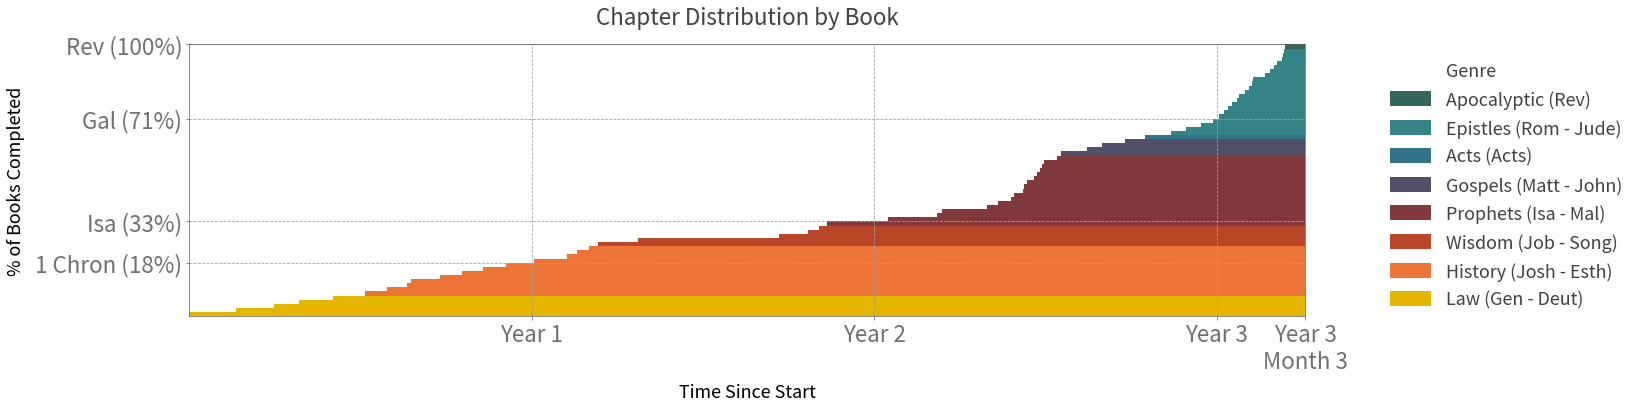

In [90]:
groups = bible.groupby("Genre",sort=False)

# Construct Colors
color_pal = get_color("palette")(len(groups))
color_dict = dict()
ind = 0
for name, _ in groups:
    color_dict[name] = color_pal[ind]
    ind += 1

# Construct Genre Legends
g_legends = [mpatches.Patch(color=bg_color,label="Genre")]
for name, group in groups:
    legend_text = name + " (" + group.index[0]
    if (len(group.index) > 1):
        legend_text += " - " + group.index[-1]
    legend_text += ")"
    g_legends.insert(1,mpatches.Patch(color=color_dict[name], label=legend_text))


plt.figure(figsize=(20,5))
    
# Create Plots
yticks = []
ylabels = []
x_progress = 0
x_length = sum(bible["Chapters"])
y_progress = 0
y_length = len(bible["Chapters"])               
for name, group in groups:

    row_ids = [ bible.index.get_loc(i) for i in group.index ]

    # Part 1: Bars When Genre Is Still Being Read
    length = 0
    # For each book in the genre
    for idx in row_ids:

        # If we are reading this book in the anniversary 
        if (math.floor((x_progress + length)/365) < math.floor((x_progress + length + bible["Chapters"][idx])/365)):
            yticks.append(idx + 1)
            ylabels.append("{} ({}%)".format(bible.index[idx],round(idx/y_length * 100)))

        plt.broken_barh([(x_progress + length, bible["Chapters"][idx])],
                        (y_progress, (idx + 1) - y_progress),
                        facecolors = color_dict[name])
        length += bible["Chapters"][idx]
    
    
    # Part 2: Bars When Genre has Been Read
    plt.broken_barh([(x_progress + length, x_length - x_progress - length)],
                    (y_progress, max(row_ids) + 1 - y_progress), 
                    facecolors = color_dict[name])
    
    x_progress += length
    y_progress = max(row_ids) + 1
    


# Add Titles and Grid
plt.title("Chapter Distribution by Book")
plt.grid(color=fade_color(ltxt_color,0.5), linestyle='dashed')

# Add X-Axis Details
plt.xlabel("Time Since Start")
xticks = [365, 2 * 365, 3 * 365 ,sum(bible["Chapters"])]
xlabels = [ "Year 1", "Year 2", "Year 3", "Year 3\nMonth 3" ]
plt.xticks(xticks, xlabels)
plt.xlim(0,x_length)

# Add Y-Axis Details
yticks.append(y_length)
ylabels.append("{} ({}%)".format(bible.index[-1],round(1 * 100)))
plt.ylabel("% of Books Completed")
plt.yticks(yticks, ylabels)
plt.ylim(0, y_length)

# Add Legends
plt.legend(handles=legends, bbox_to_anchor=[1.3, 1.0])

plt.show()

By the 1st year, we will have only completed 18% of the books on the bible. If this is not discouraging enough, after a further year, we would still not have completed the Old Testament (Law to Prophets). However, upon reaching the New Testament (Gospels to Apocalyptic) at the middle of the 2nd year, we could complete the whole set of books within 9 months. The Old Testament is more than 3 times longer than the New Testament!

####  Chapter Length

Assuming that the average human reads 200 words per minute, we can also estimate how long it will take to read 1 chapter every day:

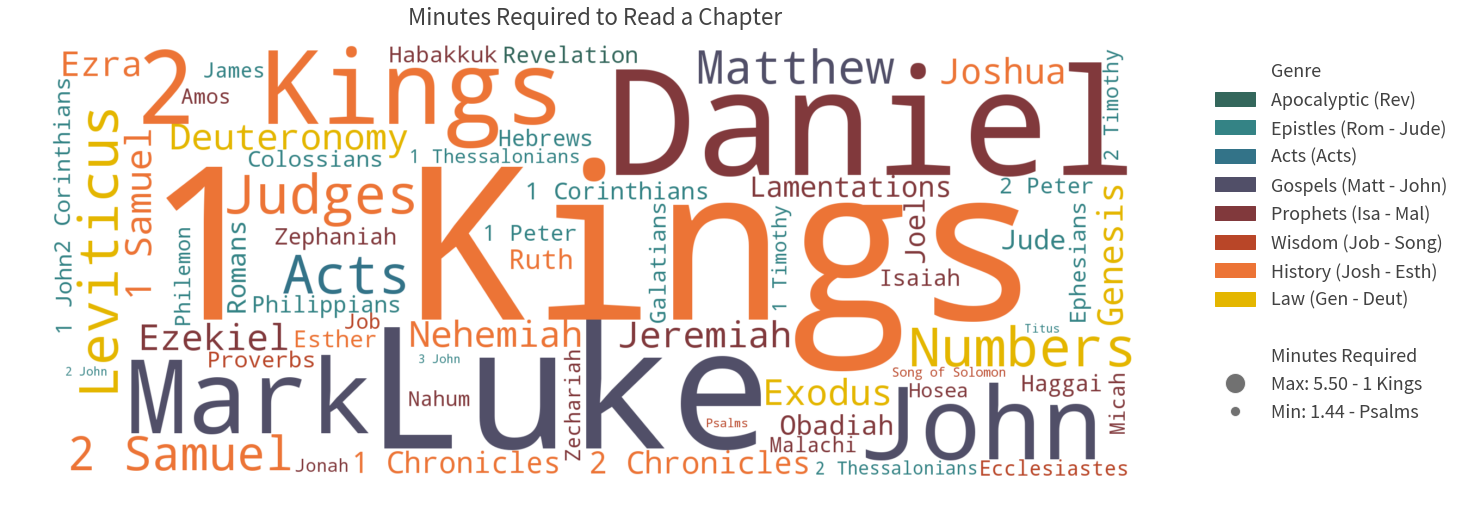

In [92]:
def word_cloud(input, fig_size = (20,10), image = None, colors = None):
    
    # Step 1: If there is an image specified, we need to create a mask
    mask = None
    if (image != None):
        mask = np.array(PIL.Image.open(image))
        if (colors == "image_colors"):
            colors = wordcloud.ImageColorGenerator(mask)
    
    # Step 2: Set up default colors
    def_colors = mpl.colors.ListedColormap(get_color())
    
    # Step 3: Generate Word Cloud
    #https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
    wc = wordcloud.WordCloud(height=fig_size[1]*100,
                             width=fig_size[0]*100,
                             background_color=bg_color,
                             mask = mask,
                             colormap = def_colors,
                             color_func = colors).generate_from_frequencies(input)

    # Step 4: Plot Word Cloud
    plt.figure(figsize=fig_size)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

# ----------------------------------------------------------------------------------------------------

# 200 Words Per Minute is the Average Reading Speed
bible["Minutes_p_Chapter"] = 1. * bible["Words"] / bible["Chapters"] / 200
inputs = OrderedDict((bible['Name'][n], k) for n,k in bible["Minutes_p_Chapter"].iteritems())

# Define color functions
def color_func(word, font_size, position, orientation, **kwargs):
    return color_dict[bible[bible["Name"] == word]["Genre"].str.cat()]

# Create Word Cloud
word_cloud(inputs, fig_size=(20,8), colors = color_func)

# Create Title
plt.title("Minutes Required to Read a Chapter")

# Legends
legends_cloud = []
# Genre Legends
legends_cloud.extend(g_legends)
# Spacing
legends_cloud.append(mpatches.Patch(color=bg_color,label=""))
# Min-Max Legends
# Add Header for Legends
legends_cloud.append(mpatches.Patch(color=bg_color,label="Minutes Required"))
max_item = max(inputs.items(), key=operator.itemgetter(1))
legends_cloud.append(mlines.Line2D([0], [0], marker='o', color=bg_color, label="Max: " + "{:.2f}".format(max_item[1]) + " - " + max_item[0],
                      markerfacecolor=ltxt_color, markersize=20))
min_item = min(inputs.items(), key=operator.itemgetter(1))
legends_cloud.append(mlines.Line2D([0], [0], marker='o', color=bg_color, label="Min: " + "{:.2f}".format(min_item[1]) + " - " + min_item[0],
                      markerfacecolor=ltxt_color, markersize=10))
plt.legend(handles=legends_cloud, bbox_to_anchor=[1.3, 1])

# Show Figure
plt.show()
    

From the chart above, we conclude that chapter length across books are varied as well. For example, a chapter in <span class="hl orange-text">1 Kings</span> will take around 5.5 minutes to read, whilst a chapter in <span class="hl red-text">Psalms</span> will take around 1.5 minutes to read. 

### Preliminary Insights

#### Faces of God

#### Major Characters

## Preparation

### Finding the Characters

### Cleaning Up the Errors

### Insights

## Constructing the Network

### Building Networks and Edges

### The Social Network

### Network Slices

## Summary of Results